Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

Подберите параметры модели SARIMAX для этого ряда.

Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


In [3]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data_m = data.resample('M').mean()
data_m.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000
2002-04-30,28534.731572,2002.0,4.0,15.511822,2.0,105.511822,15.668985,2.828929,11.511822,0.000000,0.000000,0.000000
2002-05-31,28073.653226,2002.0,5.0,16.000000,2.0,136.000000,20.000000,3.000000,11.500000,0.032258,0.032258,0.032258


Проверим автокорелляции

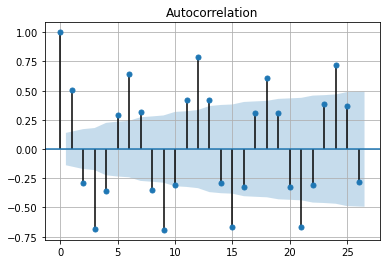

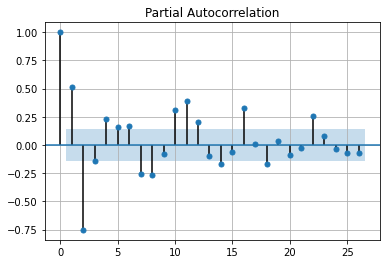

In [4]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=26)
plt.grid(True)

plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.grid(True)

plt.show()

На месячном графике можно увидеть, что есть ежегодный цикл (лаги 12 и 24) для ACF MA(12) и PACF AR(12). Также по ACF заметны полгуодовые циклы (лаги 6 и 18), которые на PACF не очень значительны.

Задаем сетку параметров:

In [22]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

# зададим сезонность p, d и q
p = d = q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [7]:
warnings.filterwarnings("ignore")
res = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            res.append( param + param_seasonal + (results.aic,) )
        except:
            continue

Лучшие результаты:

In [8]:
pd.DataFrame(res,columns=['p','d','q','Ps','Ds','Qs','m','AIC']).sort_values(['AIC']).head(3)

,p,d,q,Ps,Ds,Qs,m,AIC
395,1,1,2,1,2,2,12,2438.806668
152,0,1,2,1,2,2,12,2442.082597
143,0,1,2,0,2,2,12,2442.229207


Построим модель на лучших параметрах SARIMAX(1,1,2)x(1,2,2,12)

In [81]:
mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-6],
                                order=[1,1,2],
                                seasonal_order=[1,2,2,12] ,
                                enforce_stationaity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print(f'AIC: {results_opt.aic}')

AIC: 3087.3017451043006


In [82]:
print(results_opt.summary().tables[0])
print( results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  194
Model:             SARIMAX(1, 1, 2)x(1, 2, 2, 12)   Log Likelihood               -1536.651
Date:                            Sun, 10 May 2020   AIC                           3087.302
Time:                                    20:20:44   BIC                           3109.211
Sample:                                         0   HQIC                          3096.193
                                            - 194                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1252      1.387     -0.090      0.928      -2.843       2.593
ar.L2         -0.2255      0.368   

Проверим ватокорелляцию на остатках:

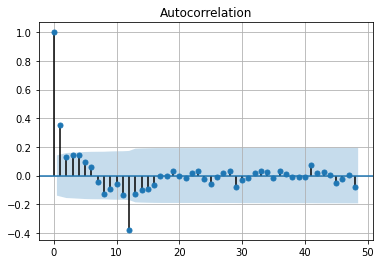

In [83]:
sm.graphics.tsa.plot_acf(results_opt.resid, lags=48)
plt.grid(True)
plt.show()

На лаге 12 заметна некоторая отрицательная автокорелляция, но в остальном нет.

Посмотрим красивые графики:

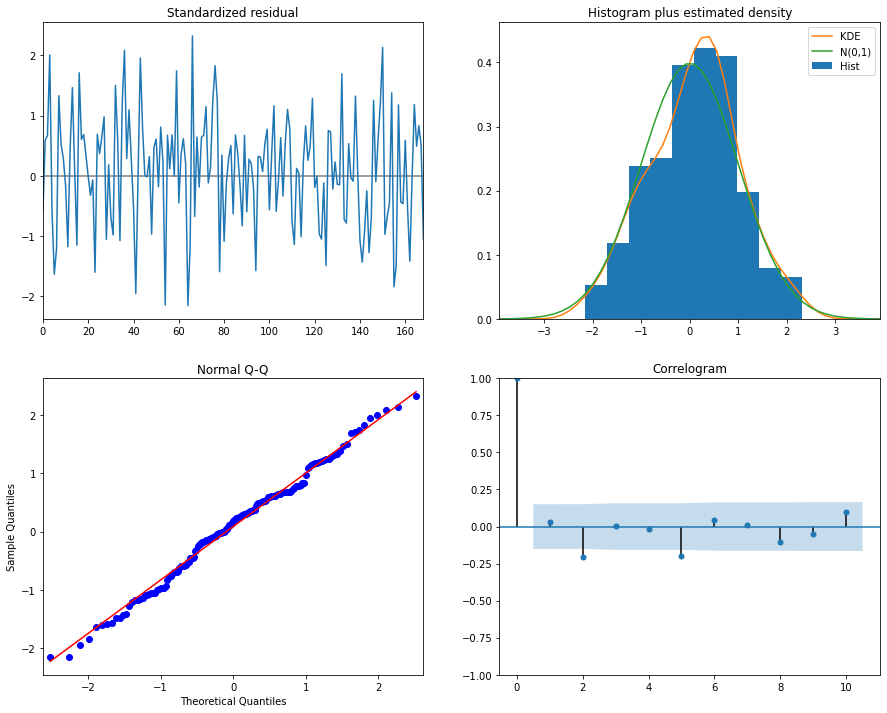

In [84]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()

По графикам видно, что распределение остатков достаточно хорошо соответствует нормальному закону. Значит модель хорошо отделяет сезонную часть.

Предскажем последние 6 точек (полгода), (которые нам известны) и еще 6 точек, заранее не известных:

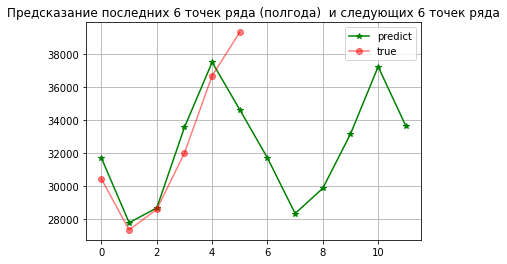

In [87]:
pred_dynamic_opt = results_opt.forecast(12)

plt.plot(pred_dynamic_opt, '*-g', label='predict')
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-6:], 'o-r', label='true', alpha=0.5)

plt.title('Предсказание последних 6 точек ряда (полгода)  и следующих 6 точек ряда')
plt.legend()
plt.grid(True)

plt.show()

Модель хорошо предсказала на 5 месцев вперед, а шестой месяц плохо.
По сравнению с недельными предсказниями график более гладкий.

Возмите вариант 1 или 2

Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках ) 

https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv тут можно скачать актуальные данные. 

Оцените результат моделирования

Датасет по ковиду на 9 мая 2020 г.

In [122]:
Path_covid = 'covid_19_data.csv'
covid = pd.read_csv(Path_covid, index_col=[1], parse_dates=[1])
covid.head()

,SNo,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,
2020-01-22,1,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,2,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2020-01-22,3,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
2020-01-22,4,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,5,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


Подготовим выборку по ежедневному приросту подтвержденных диагнозов для России, начиная с марта (так как до марта практически не было ежедневного прироста)

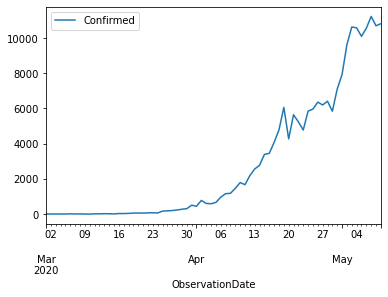

In [344]:
covid_rus = covid.loc[covid['Country/Region']=='Russia',['Confirmed']].diff()[30:]

covid_rus.plot()

На первый взгляд сезонности не наблюдаются, имеется ярко выраженный тренд.

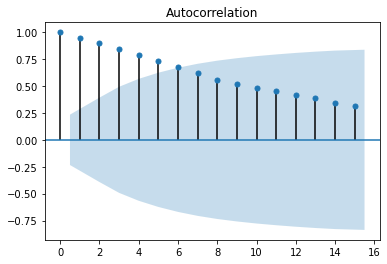

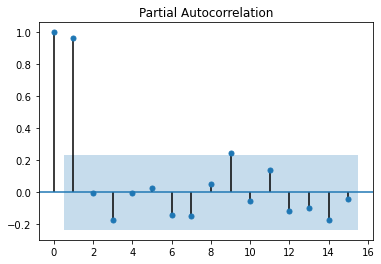

In [345]:
sm.graphics.tsa.plot_acf(covid_rus['Confirmed'].values, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(covid_rus['Confirmed'].values, lags=15)
plt.show()

Дневные графики показывают автокорреляцию ежедневного прироста со всеми значениями ранее (это не очень хорошо) и на PACF  видно, что только 1-й порядок разностей важен для процесса (AR 1). Это полностью согласуется с проведенным ранее анализом. Запустим модель без сезонного анализа (ARIMA)

In [346]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)

# Зададим виды трендов: 
# 'ct' константа + линейный, 
# полиномы 2 степени, 

trends = ('ct',[0,0,1],[1,0,1],[0,0,1])

# зададим сетку p, d, q и trends
pdqt = list(itertools.product(p, d, q, trends))

len(pdqt)

108

In [369]:
warnings.filterwarnings("ignore")
resc = []
for param in pdqt:
    try:
        model_c = sm.tsa.statespace.SARIMAX(covid_rus['Confirmed'].values[:-4],
                                            order=param[:-1],
                                            seasonal_order=[0,0,0,0],
                                            trend=param[-1],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        results_c = model_c.fit()
        resc.append( param + (results_c.aic,) )
    except:
        continue

In [370]:
pd.DataFrame(resc,columns=['p','d','q','trend','AIC']).sort_values(['AIC']).head(3)

,p,d,q,trend,AIC
32,0,2,2,ct,936.467735
35,0,2,2,"[0, 0, 1]",938.360794
33,0,2,2,"[0, 0, 1]",938.360794


Выберем модель ARIMA(0,2,2) с линейным трендом.

In [371]:
model_covid = sm.tsa.statespace.SARIMAX(covid_rus['Confirmed'].values[:-4],
                                        order=[0,2,2],
                                        seasonal_order=[0,0,0,0],
                                        trend='ct',
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_covid = model_covid.fit()

print(f'ARIMA(1,2,2) - AIC:{results_covid.aic}')
print('='*78)
print(results_covid.summary().tables[0])
print(results_covid.summary().tables[1])

ARIMA(1,2,2) - AIC:936.4677348611765
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   66
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -463.234
Date:                Sun, 10 May 2020   AIC                            936.468
Time:                        23:38:52   BIC                            947.022
Sample:                             0   HQIC                           940.604
                                 - 66                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.1039     15.346     -0.072      0.943     -31.181      28.973
drift          0.2801      0.388      0.722      0.470      -0.481       1.041
ma.L1         -

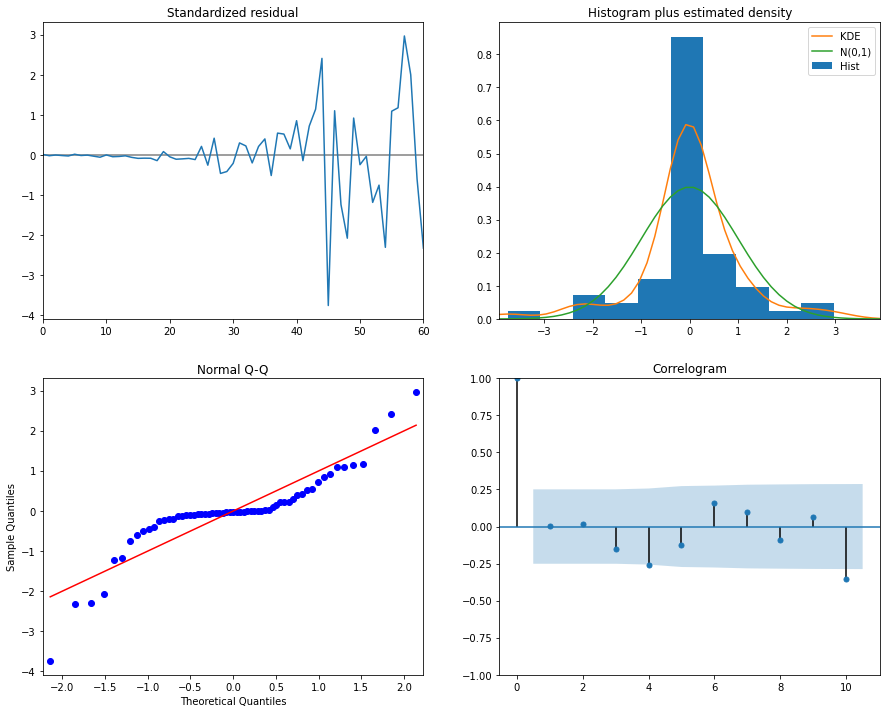

In [372]:
results_covid.plot_diagnostics(figsize=(15, 12))
plt.show()

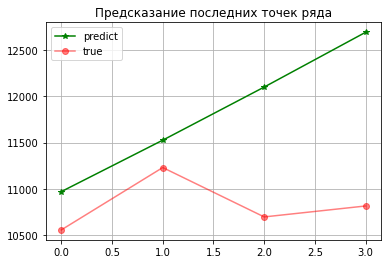

In [373]:
pred_dynamic_covid = results_covid.forecast(4)

plt.plot(pred_dynamic_covid, '*-g', label='predict')
#Отобразим истинный значения 
plt.plot(covid_rus['Confirmed'].values[-4:], 'o-r', label='true', alpha=0.5)

plt.title('Предсказание последних точек ряда')
plt.legend()
plt.grid(True)

plt.show()

С увеличением горизонта прогноза, расхождения усиливаются. Точность невысокая, так как исторических данных мало, а примеры развития пандемии в других странах показывают, что изменение ежедневного прироста подтвержденных диагнозов имеет колоколообразный характер, то есть тренд со временем будет хуже предсказывать, а после прохождения "пика" совсем не будет работать.